# Apply a perturbation to a cross section over its entire energy domain

In [1]:
import os

import numpy as np
import pandas as pd

In [4]:
import sandy

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In this notebook we learn to:
* generate a uniform cross section perturbation over the entire cross section domain;
* apply the perturbation to the cross section;
* plot the results;
* produce an ACE file with the perturbed cross section.

## Retrieve nuclear data file

Firs, we get the evaluated nuclear data file - in this case U-238 from ENDF/B-VII - using `get_endf6_file`.
We also proceed in reconstructing the cross sections from the resonance parameters using NJOY (RECONR) and method `.get_pendf`.

In [5]:
endf6 = sandy.get_endf6_file("endfb_71", "xs", 922380)
pendf = endf6.get_pendf(err=0.1, verbose=True)

moder
20 -21 /
reconr
-21 -22 /
'sandy runs njoy'/
9237 0 0 /
0.1 0. /
0/
moder
-22 30 /
stop


Basically we produced a so-called PENDF file, from which we can extract the cross sections.

In [6]:
xs = sandy.Xs.from_endf6(pendf)

## Create a perturbation

To create a perturbation over the whole cross section energy domain you have first to define the domain boundaries.

In [7]:
lower_bound = 1e-5  # eV
upper_bound = 2e7   # eV

Then the domain is,

In [8]:
domain = [lower_bound, upper_bound]

We define a large perturbation coefficient to make sure the perturbation is visible whne we plot it. Let's say 30%.

In [9]:
coefficient = 30 / 100

Now, a perturbation is defined in the following way:

In [10]:
pert_plus = sandy.Pert([1, 1 + coefficient], index=domain)

The first `1` in the intitialized values indicate that everything below the domain lower bound must be multiplied by one, i.e. it doesn't change!

Since we defined a positive perturbation, we can also make a negative one for completeness (let's say 50%).

In [11]:
coefficient_minus = 50 / 100
pert_minus = sandy.Pert([1, 1 - coefficient_minus], index=domain)

## Apply perturbations to cross sections

Below we apply both perturbations to the inelatsic cross section (MT=4) of U-238 (MAT=9237).

In [12]:
mat = 9237
mt = 4
xspert_plus = xs.custom_perturbation(mat, mt, pert_plus)
xspert_minus = xs.custom_perturbation(mat, mt, pert_minus)

## Plot the results

Results show clearly that the poitwise cross sections have been modified by the perturbation.

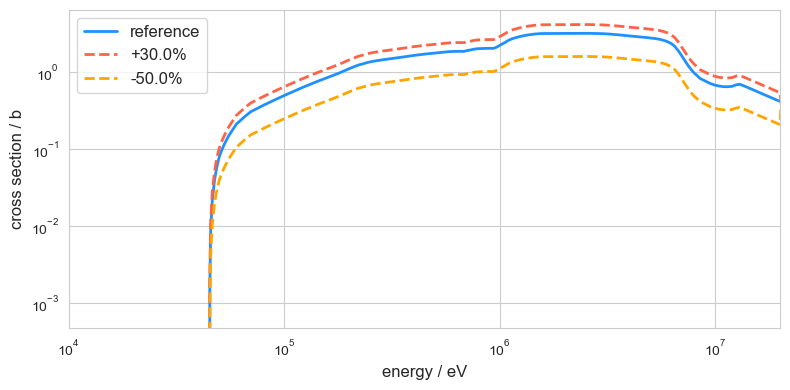

In [13]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

ax = xs.data[(mat, mt)].plot(logx=True, logy=True, color="dodgerblue", linewidth=2, ax=ax, label="reference")
ax = xspert_plus.data[(mat, mt)].plot(
    logx=True,
    logy=True,
    color="tomato",
    style='--',
    linewidth=2,
    ax=ax,
    label=f"+{coefficient * 100}%",
)
ax = xspert_minus.data[(mat, mt)].plot(
    logx=True,
    logy=True,
    color="orange",
    style='--',
    linewidth=2,
    ax=ax,
    label=f"-{coefficient_minus * 100}%",
)

ax.legend(prop={"size": "large"})

ax.set_ylabel("cross section / b", fontsize="large")
ax.set_xlabel("energy / eV", fontsize="large")

ax.set_xlim([1e4, 2e7])

fig.tight_layout();

Notice than neither derived cross section, e.g. MT=1, nor cross section components, e.g. MT=51, where adjusted by method `.custom_perturbation`. 

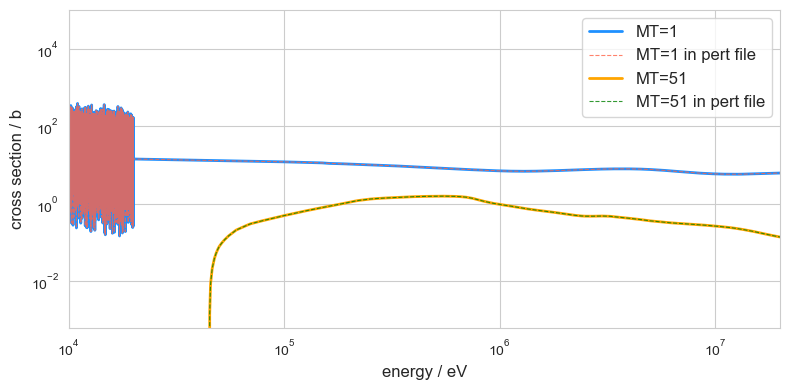

In [14]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

ax = xs.data[(mat, 1)].plot(logx=True, logy=True, color="dodgerblue", linewidth=2, ax=ax, label="MT=1")
ax = xspert_plus.data[(mat, 1)].plot(
    logx=True,
    logy=True,
    color="tomato",
    style='--',
    linewidth=0.8,
    alpha=0.8,
    ax=ax,
    label="MT=1 in pert file",
)

ax = xs.data[(mat, 51)].plot(logx=True, logy=True, color="orange", linewidth=2, ax=ax, label="MT=51")
ax = xspert_plus.data[(mat, 51)].plot(
    logx=True,
    logy=True,
    color="green",
    style='--',
    linewidth=0.8,
    alpha=0.8,
    ax=ax,
    label= "MT=51 in pert file",
)

ax.legend(prop={"size": "large"})

ax.set_ylabel("cross section / b", fontsize="large")
ax.set_xlabel("energy / eV", fontsize="large")

ax.set_xlim([1e4, 2e7])

fig.tight_layout();

## Create a ACE file out of perturbed nuclear data

Peturbed ENDF-6/PENDF files can be useful for visualozation or direct data manipulation, but they are not very handy when we need to run transport calculations, since most of the transport codes read data in derived formats.

Here we convert a perturbed PENDF file into a perturbed ACE file that can be used by MCNP or Serpent. The general issue associated to this is that we need to combine the original ENDF-6 file with the perturbed PENDF file (where the perturbed cross section is) in order to produce the perturbed ACE file. This can be cumbersome and as the NJOY processing sequence must be adjusted!

Luckily, SANDY's `.get_ace` takes specific keywords to allow a ENDF-6 file and a PENDF file to be combined. Just pass the `sandy.Endf6` object associated to the PENDF file to keyword argument `pendf`, as reported below.

In [16]:
pendf_pert = xspert_plus.to_endf6(pendf)

tag = "_pert"
outs = endf6.get_ace(temperature=900, heatr=False, thermr=False, gaspr=False, purr=False, verbose=True, pendf=pendf_pert)
with open("92238_pert.09c", mode="w") as f:
    f.write(outs["ace"])

moder
20 -21 /
moder
99 -22 /
broadr
-21 -22 -23 /
9237 1 0 0 0. /
0.001 /
900.0 /
0 /
moder
-23 30 /
acer
-21 -23 0 50 70 /
1 0 1 .09 0 /
'sandy runs acer'/
9237 900.0 /
1 1 /
/
stop


> The  temperature argument is required! If you perturb cross sections it is good practice to do it on PENDF files without any doppler-broadening. The doppler-broadening is already included in the ACE production scheme.

Running `.get_ace` with a `pendf` keyword makes NJOY skip RECONR, as the reconstructed (and perturbed) cross sections are already present in the PENDF file. To simplify the scheme we removed HEATR, THERMR, GASPR and PURR from the processing sequence, but we advise against this in real studies. 

The output of `.get_ace` is a dictionary with the filenames associated to:
* the ACE file
* the XSDIR file (one line only, corrsponding to the produced ACE)

Notice that we asked `.get_ace` to add a tag `'_pert'` to distinguish the ACE file. The rest of the name is determined by a SANDY internal routine.